<a href="https://colab.research.google.com/github/Pragyan127/Deep-Neural-Networks-for-Disease-Classification-from-Endoscopic-Imaging/blob/main/endoscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas


In [ ]:
import pandas as pd

In [ ]:
pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras pydot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install opencv-python

In [ ]:
# Import system libraries and set up environment
import os
import sys
import random
import time
import itertools
from glob import glob

# Import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV for image processing
from tqdm import tqdm_notebook

# Set visualization styles
sns.set_style('darkgrid')
%matplotlib inline

# Import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check for GPU and CUDA configuration
device_name = tf.test.gpu_device_name()
if device_name:
    print(f'GPU "{device_name}" detected and set as default device.')
else:
    print("No GPU detected. Make sure CUDA is properly installed.")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("Modules loaded successfully.")

No GPU detected. Make sure CUDA is properly installed.
Modules loaded successfully.


In [ ]:
# Define constants for image dimensions and paths
IMG_HEIGHT, IMG_WIDTH = 256, 256
IMG_CHANNELS = 3
DATA_PATH = './data/kvasir-seg'  # Replace with your dataset path

# Load image and mask file names
X_ids = sorted(next(os.walk(os.path.join(DATA_PATH, 'images')))[2])
y_ids = sorted(next(os.walk(os.path.join(DATA_PATH, 'masks')))[2])

# Initialize empty arrays for images and masks
X_train = np.zeros((len(X_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y_train = np.zeros((len(y_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  # For mask, single channel

# Preprocess the images and masks
def preprocess_images(image_list, img_path):
    images = np.zeros((len(image_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    for n, image_id in enumerate(image_list):
        image = tf.keras.preprocessing.image.load_img(os.path.join(img_path, image_id), target_size=(IMG_HEIGHT, IMG_WIDTH))
        images[n] = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    return images

def preprocess_masks(mask_list, mask_path):
    masks = np.zeros((len(mask_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for n, mask_id in enumerate(mask_list):
        mask = tf.keras.preprocessing.image.load_img(os.path.join(mask_path, mask_id), target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        masks[n] = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
    return masks

# Apply preprocessing functions
X_train = preprocess_images(X_ids, os.path.join(DATA_PATH, 'images'))
y_train = preprocess_masks(y_ids, os.path.join(DATA_PATH, 'masks'))

print("Training images and masks preprocessed successfully.")

Training images and masks preprocessed successfully.


In [ ]:
# Define the U-Net model
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    # Encoder / Downsampling path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder / Upsampling path
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

model = unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 512)       │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 16, 16, 512)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 16, 1024)      │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 16, 16, 1024)      │       9,438,208 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 32, 32, 512)       │       2,097,66

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7806 - loss: 0.6203 
Epoch 1: val_loss improved from inf to 0.40472, saving model to unet_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 813s 14s/step - accuracy: 0.7814 - loss: 0.6191 - val_accuracy: 0.8437 - val_loss: 0.4047
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8484 - loss: 0.3943 
Epoch 2: val_loss improved from 0.40472 to 0.40056, saving model to unet_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 901s 16s/step - accuracy: 0.8483 - loss: 0.3943 - val_accuracy: 0.8437 - val_loss: 0.4006
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8408 - loss: 0.3753 
Epoch 3: val_loss did not improve from 0.40056
57/57 ━━━━━━━━━━━━━━━━━━━━ 874s 15s/step - accuracy: 0.8408 - loss: 0.3751 - val_accuracy: 0.8437 - val_loss: 0.4394
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8403 - loss: 0.3703 
Epoch 4: val_loss improved from 0.40056 to 0.33054, saving model to unet_model.keras
57/57 ━

32/32 ━━━━━━━━━━━━━━━━━━━━ 282s 9s/step - accuracy: 0.9880 - loss: 0.0312
Model accuracy: 0.9824, Loss: 0.0655
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


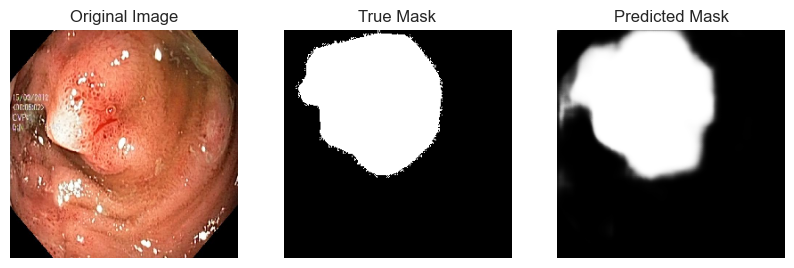

In [ ]:
# Evaluate model performance
loss, acc = model.evaluate(X_train, y_train)
print(f"Model accuracy: {acc:.4f}, Loss: {loss:.4f}")

# Predict on a sample image and display the result
sample_image = X_train[0]
sample_mask = y_train[0]
predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(np.squeeze(sample_mask), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(np.squeeze(predicted_mask), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
# Save the model
model.save('segmentation_unet_model.keras')

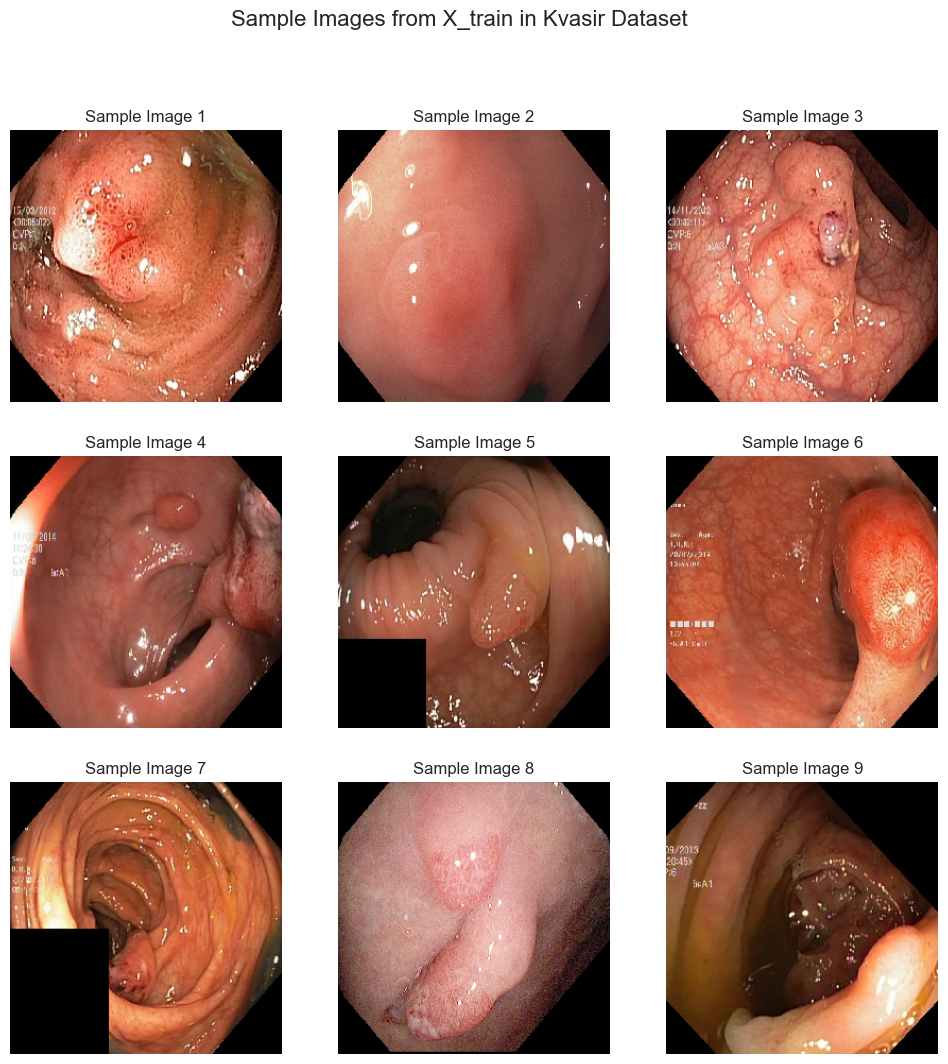

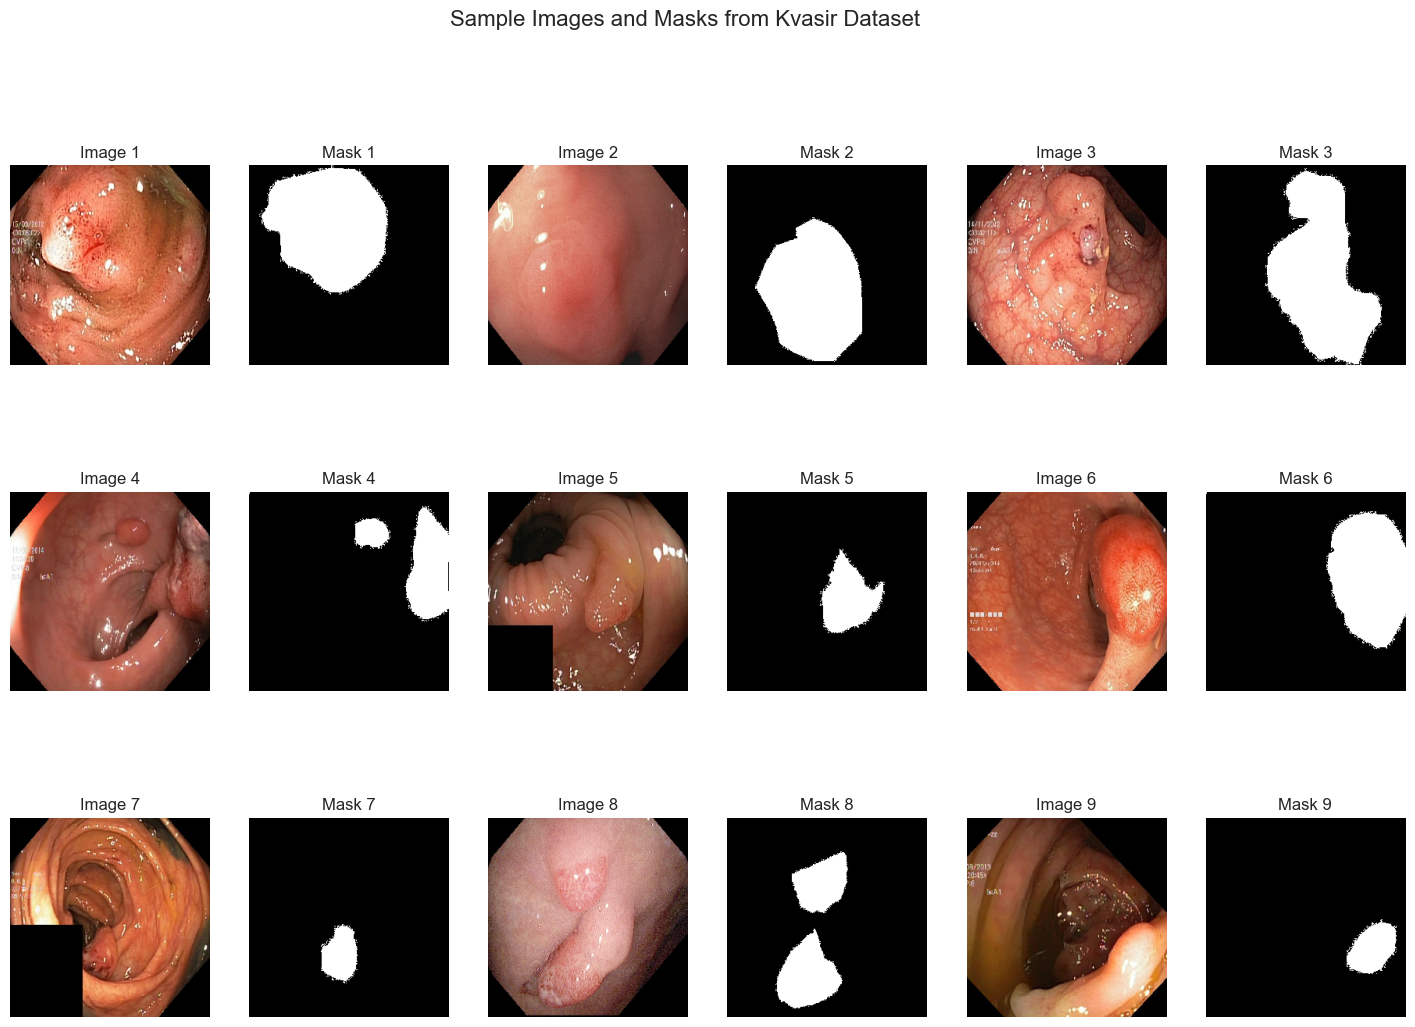

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display a grid of sample images from X_train and y_train
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(9):
    # Display image
    ax[i // 3, i % 3].imshow(X_train[i])
    ax[i // 3, i % 3].set_title(f'Sample Image {i+1}')
    ax[i // 3, i % 3].axis('off')

plt.suptitle('Sample Images from X_train in Kvasir Dataset', fontsize=16)
plt.show()
fig, ax = plt.subplots(3, 6, figsize=(18, 12))
for i in range(9):
    # Display image
    ax[i // 3, (i % 3) * 2].imshow(X_train[i])
    ax[i // 3, (i % 3) * 2].set_title(f'Image {i+1}')
    ax[i // 3, (i % 3) * 2].axis('off')

    # Display mask
    ax[i // 3, (i % 3) * 2 + 1].imshow(np.squeeze(y_train[i]), cmap='gray')
    ax[i // 3, (i % 3) * 2 + 1].set_title(f'Mask {i+1}')
    ax[i // 3, (i % 3) * 2 + 1].axis('off')

plt.suptitle('Sample Images and Masks from Kvasir Dataset', fontsize=16)
plt.show()

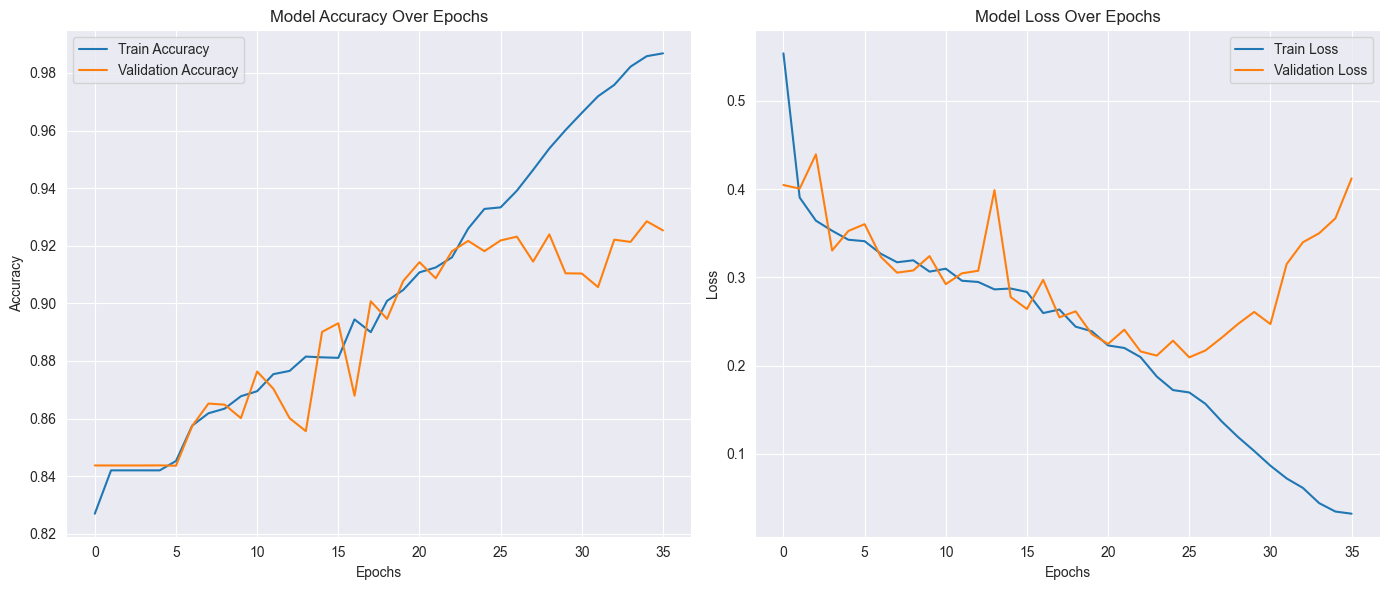

In [ ]:
# Assuming your model training history is stored in a variable 'history'
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("unet_model.keras")

In [ ]:
import os
print(os.environ['PATH'])

C:\Users\hello\AppData\Local\Programs\Python\Python312\Lib\site-packages\cv2\../../x64/vc14/bin;C:\Users\hello\AppData\Local\Programs\Python\Python38;C:\Program Files\Python38\Scripts\;C:\Program Files\Python38\;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7\libnvvp;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\NVIDIA Corporation\Nsight Compute 2022.2.0\;C:\Users\hello\Desktop\cuda\cudnn-windows-x86_64-8.9.7.29_cuda12-archive\bin;C:\Users\hello\Desktop\cuda\cudnn-windows-x86_64-8.9.7.29_cuda12-archive\include;C:\Users\hello\Desktop\cuda\cudnn-windows-x86_64-8.9.7.29_cuda12-archive\lib\x6

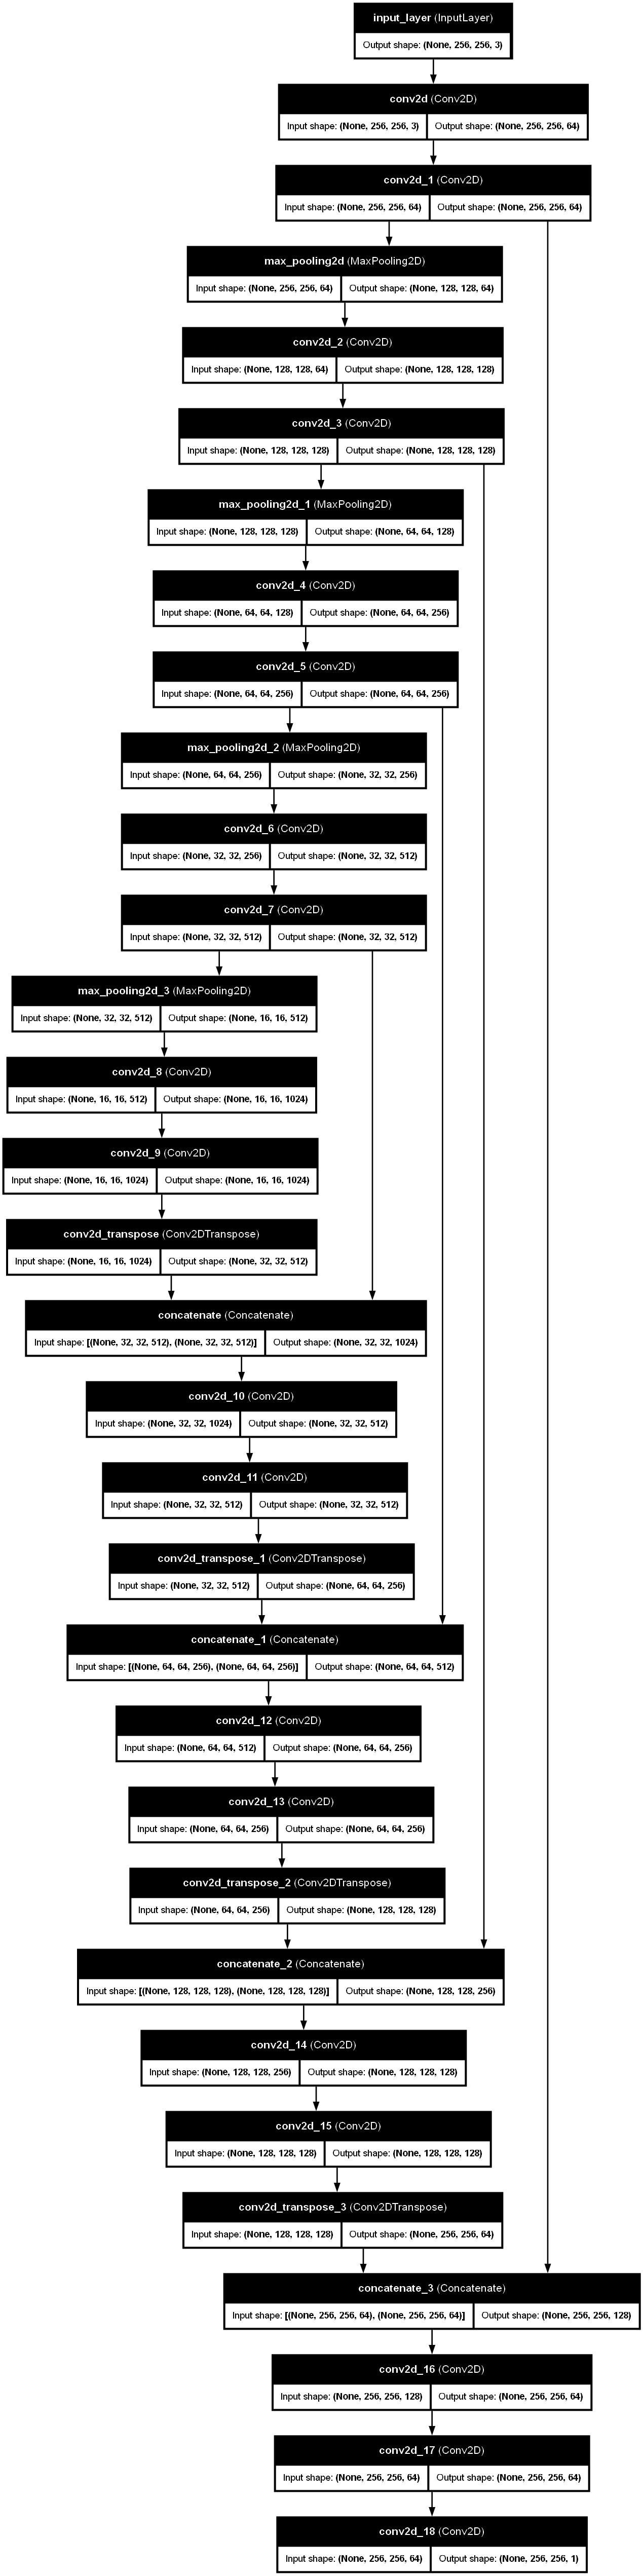

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="segmentation_unet_model.png", show_shapes=True, show_layer_names=True, dpi=96)

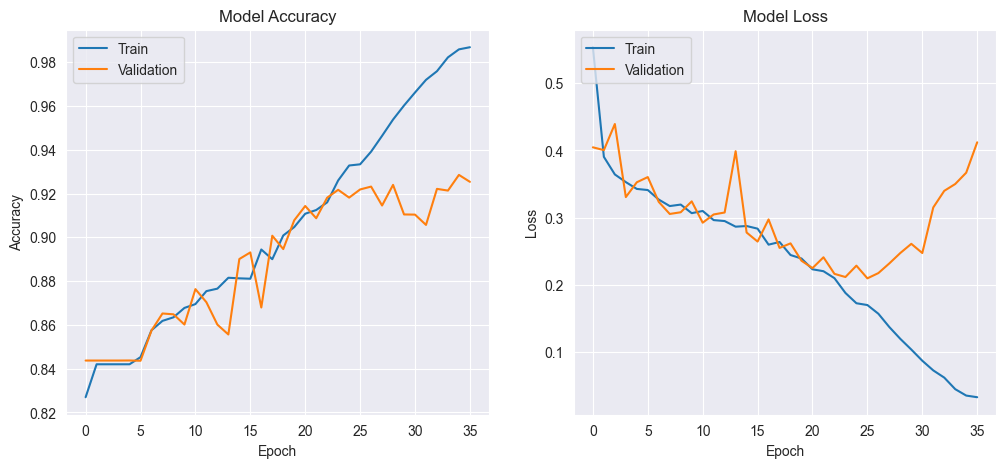

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


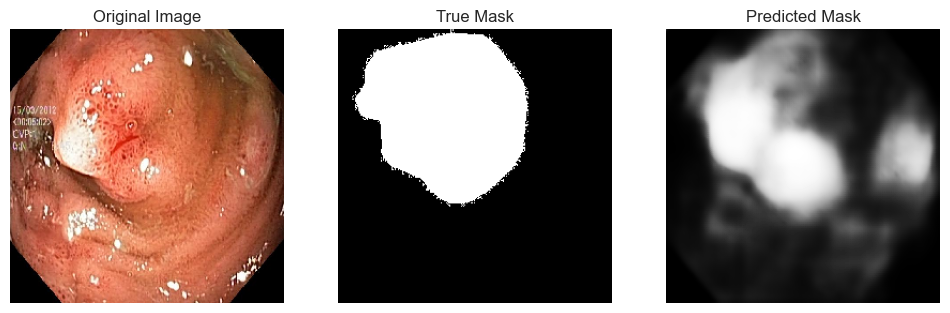

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


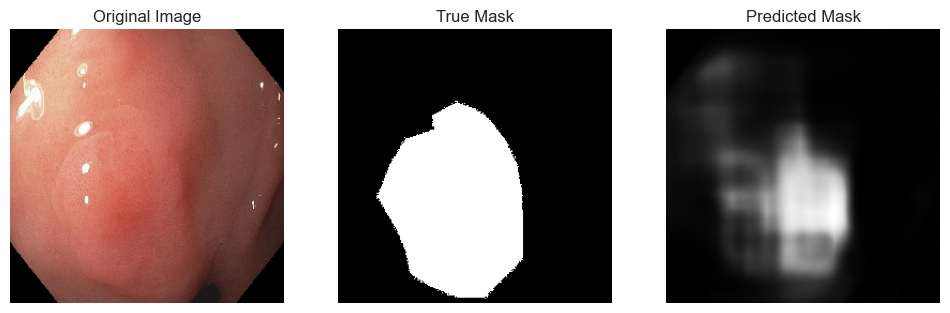

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


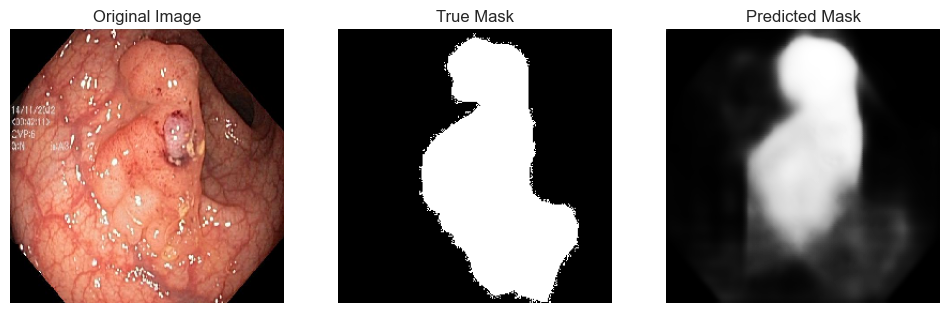

In [ ]:
import numpy as np

# Display predictions for a few sample images
for i in range(3):  # Display 3 samples
    sample_image = X_train[i]
    sample_mask = y_train[i]
    predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(sample_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(np.squeeze(sample_mask), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.squeeze(predicted_mask), cmap='gray')
    plt.axis('off')
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 294s 9s/step


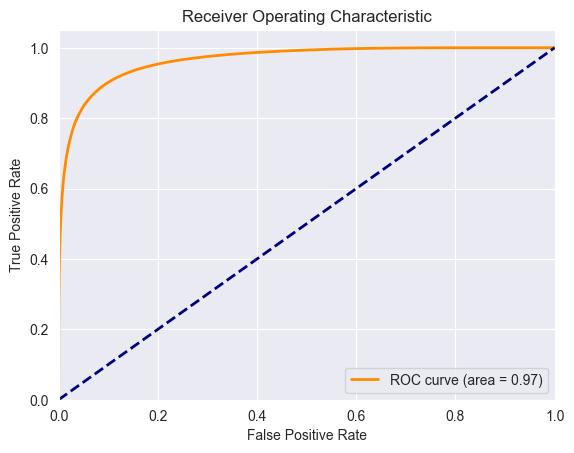

In [ ]:
from sklearn.metrics import roc_curve, auc

# Flatten the arrays for ROC calculations
y_true_flat = y_train.ravel()
y_pred_flat = model.predict(X_train).ravel()

fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 286s 9s/step


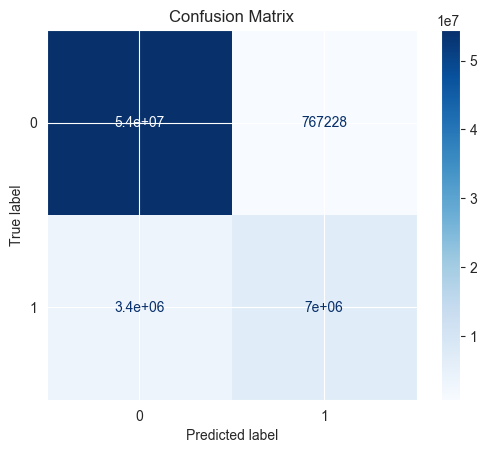

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predicted masks to binary based on a threshold (e.g., 0.5)
y_pred_binary = (model.predict(X_train) > 0.5).astype(int)
y_true_binary = y_train.astype(int)

# Flatten arrays for confusion matrix
y_true_binary_flat = y_true_binary.ravel()
y_pred_binary_flat = y_pred_binary.ravel()

# Compute confusion matrix
cm = confusion_matrix(y_true_binary_flat, y_pred_binary_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

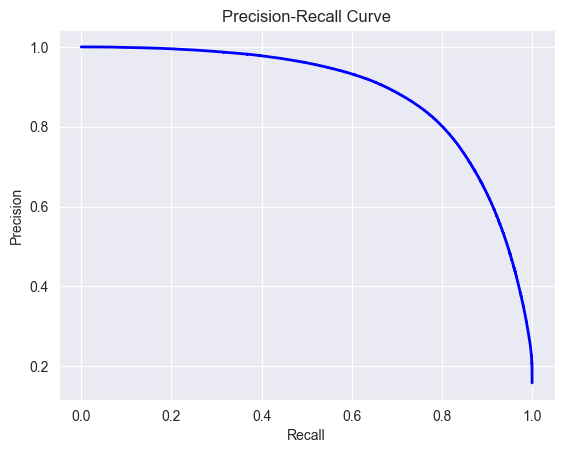

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

plt.figure()
plt.plot(recall, precision, lw=2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

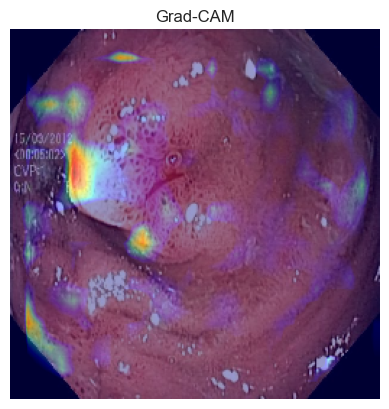

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

def grad_cam(input_model, image, layer_name):
    grad_model = Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    output = conv_outputs[0]
    grads = grads[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(output, weights)  # Dot product between output feature map and weights
    cam = cv2.resize(cam, (IMG_WIDTH, IMG_HEIGHT))  # Resize to match input image dimensions
    cam = np.maximum(cam, 0)  # ReLU-like operation to keep only positive values
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1] for display
    return heatmap

# Select a sample image and apply Grad-CAM
sample_image = X_train[0]
heatmap = grad_cam(model, sample_image, 'conv2d_7')  # Adjust 'conv2d_7' to your target layer name

# Overlay heatmap on the sample image
plt.imshow(sample_image)
plt.imshow(heatmap, cmap='jet', alpha=0.4)  # Use alpha to blend heatmap with the original image
plt.title("Grad-CAM")
plt.axis('off')
plt.show()